<a href="https://colab.research.google.com/github/Jahid14257/Bangladeshi-Dessert-Identification/blob/main/Copy_of_Bangladeshi_Dessert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
import numpy as np
import pandas as pd
import os
import keras
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2, DenseNet169, InceptionV3
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import os
import pandas as pd
import numpy as np
from keras.utils import Sequence

# Data prepr ocessing
data_dir = '/content/drive/MyDrive/Bangladeshi Dessert'
keyword= ['Balosai','Cream Jam','Doi','Dudh Puli PItha','Faluda','Golap Jam','Hafsi Sondesh','Jilapi','Kacha Golla','Kacha  Chana','Kalojam',
        'Kasmiri Chomchom','Lemon Barfi','Malaikari','Maoyaa Laddo','Nokshi Pitha','Pakon Pitha','Patishapta','Payesh',
         'Rajvog','Ravogsai','Roshmalai','S.P.Chomchom','Sada Chomchom','Sajer Pitha','Shamok Pitha','Shemai']

class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
            class_path = os.path.join(data_dir, class_folder)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(key)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
print("The classes:\n", np.unique(df['label']))


The classes:
 ['Balosai' 'Cream Jam' 'Doi' 'Dudh Puli PItha' 'Faluda' 'Golap Jam'
 'Hafsi Sondesh' 'Jilapi' 'Kacha  Chana' 'Kacha Golla' 'Kalojam'
 'Kasmiri Chomchom' 'Lemon Barfi' 'Malaikari' 'Maoyaa Laddo'
 'Nokshi Pitha' 'Pakon Pitha' 'Patishapta' 'Payesh' 'Rajvog' 'Ravogsai'
 'Roshmalai' 'S.P.Chomchom' 'Sada Chomchom' 'Sajer Pitha' 'Shamok Pitha'
 'Shemai']


In [ ]:
from sklearn.model_selection import train_test_split

labels_dict = {
    'Balosai': 0, 'Cream Jam': 1, 'Doi': 2, 'Dudh Puli PItha': 3, 'Faluda': 4, 'Golap Jam': 5, 'Hafsi Sondesh': 6,
    'Jilapi': 7, 'Kacha Golla': 8, 'Kacha  Chana': 9, 'Kalojam': 10, 'Kasmiri Chomchom': 11, 'Lemon Barfi': 12,
    'Malaikari': 13, 'Maoyaa Laddo': 14, 'Nokshi Pitha': 15, 'Pakon Pitha': 16, 'Patishapta': 17, 'Payesh': 18,
    'Rajvog': 19, 'Ravogsai': 20, 'Roshmalai': 21, 'S.P.Chomchom': 22, 'Sada Chomchom': 23, 'Sajer Pitha': 24,
    'Shamok Pitha': 25, 'Shemai': 26
}

def load_data(data_dir):
    images = []
    labels = []
    size = 64, 64
    print("LOADING DATA FROM : ", end="")
    for folder in os.listdir(data_dir):
        print(folder, end=' | ')
        for image in os.listdir(data_dir + "/" + folder):
            temp_img = cv2.imread(data_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])

    images = np.array(images)
    images = images.astype('float32') / 255.0

    labels = keras.utils.to_categorical(labels)

    # Split data into training (80%), validation (10%), and testing (10%)
    X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

    print()
    print('Loaded', len(X_train), 'images for training,', 'Train data shape =', X_train.shape)
    print('Loaded', len(X_val), 'images for validation', 'Validation data shape =', X_val.shape)
    print('Loaded', len(X_test), 'images for testing', 'Test data shape =', X_test.shape)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test
data_dir = "/content/drive/MyDrive/Bangladeshi Dessert"
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_data(data_dir)

LOADING DATA FROM : Kacha Golla | Dudh Puli PItha | Hafsi Sondesh | Kacha  Chana | Cream Jam | Jilapi | Balosai | Golap Jam | Faluda | Doi | Kasmiri Chomchom | Maoyaa Laddo | Rajvog | Kalojam | Nokshi Pitha | Pakon Pitha | Malaikari | Lemon Barfi | Payesh | Patishapta | Shemai | Sajer Pitha | Roshmalai | Ravogsai | Sada Chomchom | S.P.Chomchom | Shamok Pitha | 
Loaded 3294 images for training, Train data shape = (3294, 64, 64, 3)
Loaded 412 images for validation Validation data shape = (412, 64, 64, 3)
Loaded 412 images for testing Test data shape = (412, 64, 64, 3)


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)

## Densenet

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Load DenseNet121 model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
# Freeze the convolutional base
base_model_densenet.trainable = False

model_densenet = tf.keras.models.Sequential([
    base_model_densenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(0.7),
    tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    tf.keras.layers.Dense(units=27, activation='softmax')
])

model_densenet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)
model_densenet.summary()
history_densenet = model_densenet.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    epochs=10
)
loss, accuracy = model_densenet.evaluate(X_test, Y_test)
print("Accuracy: " + str(accuracy))
print("Loss: " + str(loss))

29084464/29084464 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

13/13 [==============================] - 9s 429ms/step
Classification Report:
                  precision    recall  f1-score   support

         Balosai       0.93      1.00      0.96        26
       Cream Jam       1.00      0.82      0.90        11
             Doi       1.00      1.00      1.00        14
 Dudh Puli PItha       1.00      0.94      0.97        17
          Faluda       0.96      1.00      0.98        24
       Golap Jam       1.00      1.00      1.00        21
   Hafsi Sondesh       1.00      1.00      1.00        12
          Jilapi       1.00      1.00      1.00        14
    Kacha  Chana       1.00      1.00      1.00        16
     Kacha Golla       1.00      1.00      1.00        20
         Kalojam       1.00      1.00      1.00        15
Kasmiri Chomchom       0.95      0.91      0.93        22
     Lemon Barfi       1.00      1.00      1.00        16
       Malaikari       1.00      1.00      1.00        13
    Maoyaa Laddo       1.00      0.87      0.93    

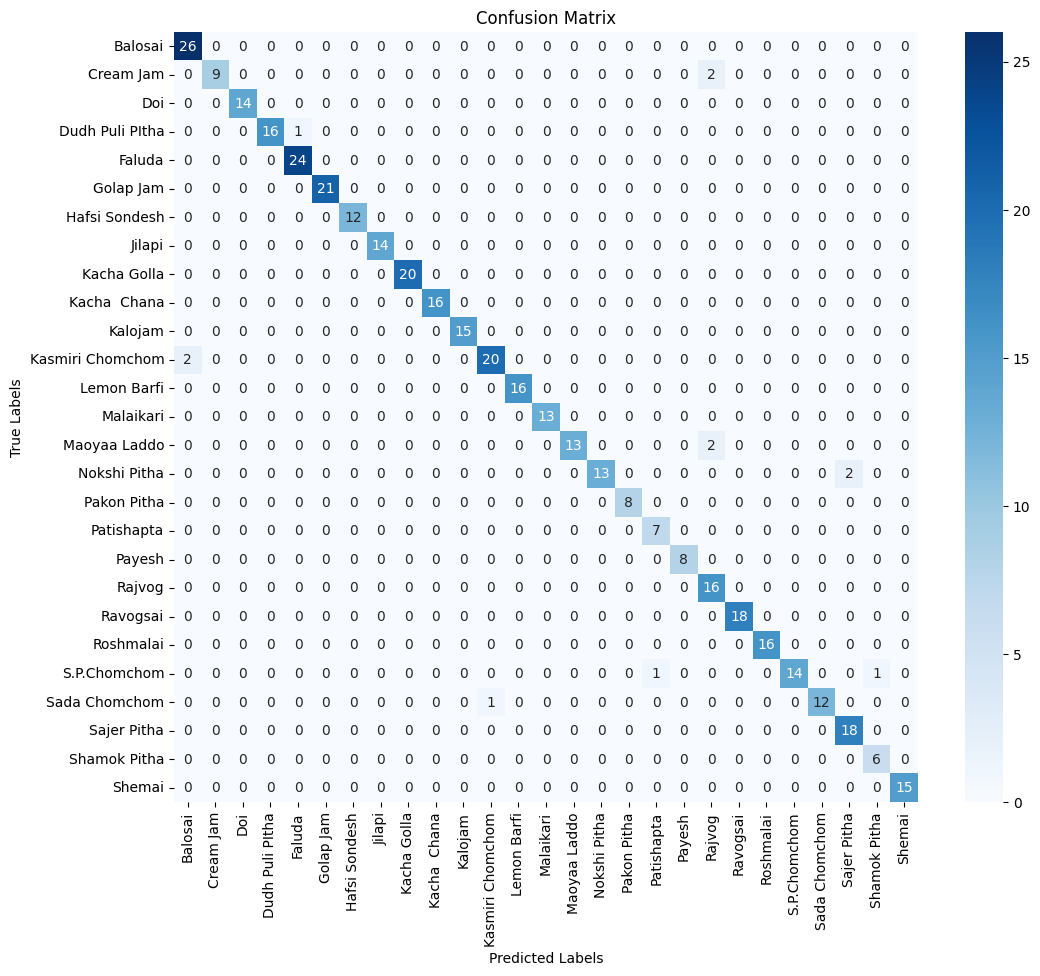

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names = list(labels_dict.keys())
Y_pred = model_densenet.predict(X_test)
Y_pred_classes = [class_names[np.argmax(pred)] for pred in Y_pred]
Y_true_classes = [class_names[np.argmax(true)] for true in Y_test]
report = classification_report(Y_true_classes, Y_pred_classes)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


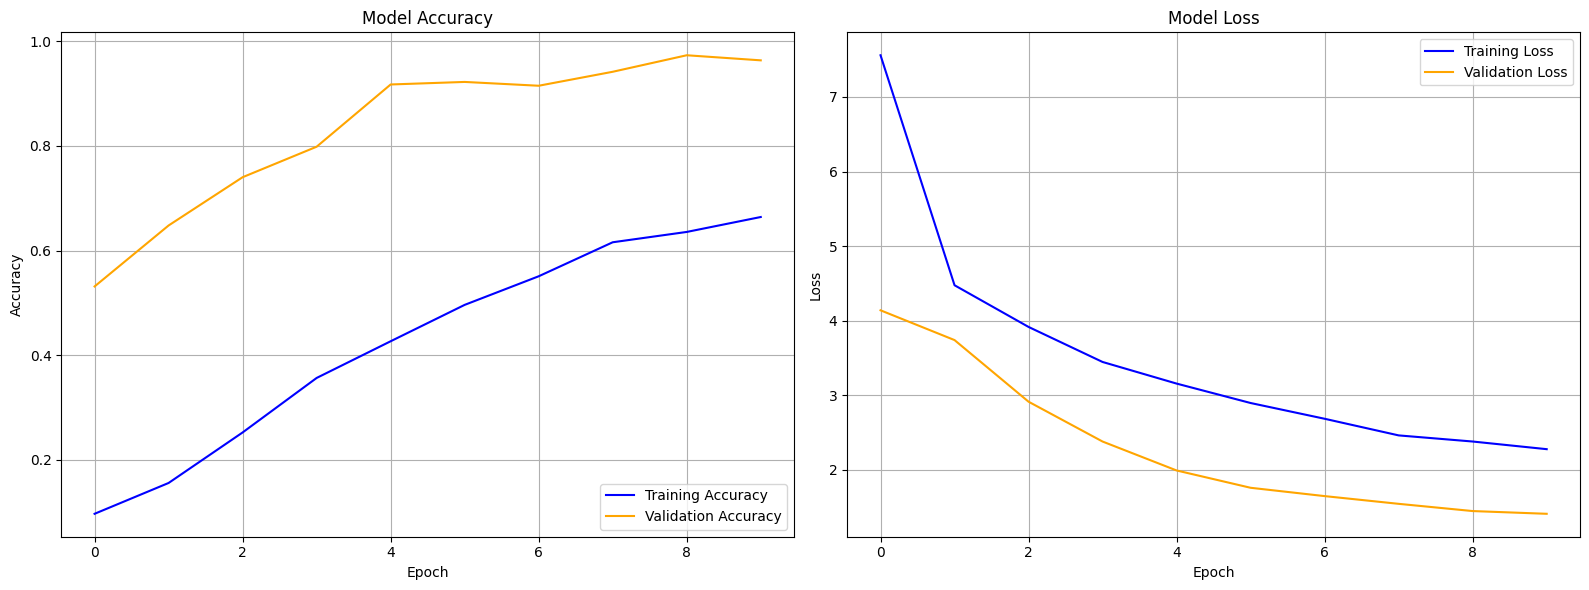

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Training Loss', color='blue')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import numpy as np
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model_mobilenet.trainable = False
model_mobilenet = tf.keras.models.Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=27, activation='softmax')
])

model_mobilenet.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)
model_mobilenet.summary()
history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    epochs=10
)
loss, accuracy = model_mobilenet.evaluate(X_test, Y_test)
print("Accuracy: " + str(accuracy))
print("Loss: " + str(loss))


17225924/17225924 [==============================] - 1s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 2, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)              

13/13 [==============================] - 2s 97ms/step
Classification Report:
                  precision    recall  f1-score   support

         Balosai       1.00      1.00      1.00        26
       Cream Jam       1.00      1.00      1.00        11
             Doi       1.00      1.00      1.00        14
 Dudh Puli PItha       1.00      1.00      1.00        17
          Faluda       1.00      1.00      1.00        24
       Golap Jam       1.00      1.00      1.00        21
   Hafsi Sondesh       1.00      1.00      1.00        12
          Jilapi       1.00      1.00      1.00        14
    Kacha  Chana       1.00      1.00      1.00        16
     Kacha Golla       0.91      1.00      0.95        20
         Kalojam       1.00      1.00      1.00        15
Kasmiri Chomchom       0.92      1.00      0.96        22
     Lemon Barfi       1.00      1.00      1.00        16
       Malaikari       1.00      1.00      1.00        13
    Maoyaa Laddo       1.00      1.00      1.00     

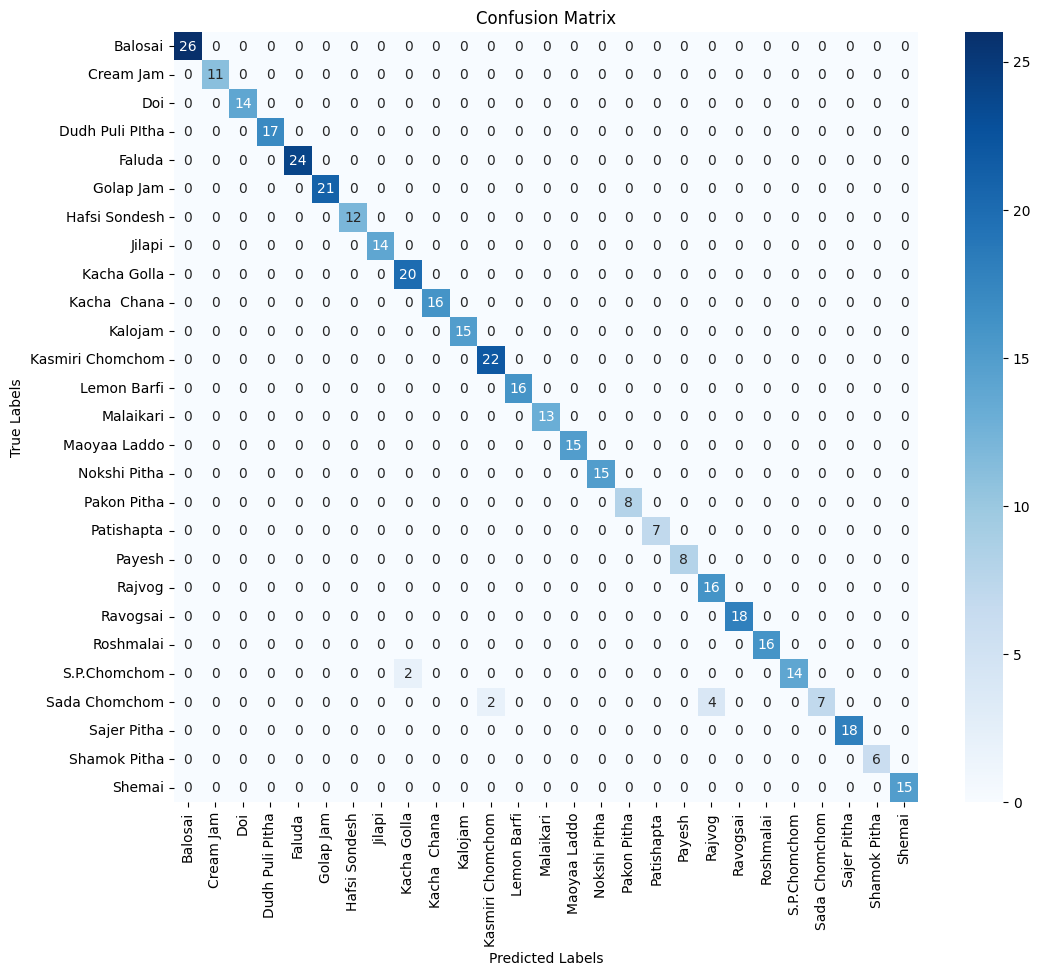

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names = list(labels_dict.keys())
Y_pred = model_mobilenet.predict(X_test)
Y_pred_classes = [class_names[np.argmax(pred)] for pred in Y_pred]
Y_true_classes = [class_names[np.argmax(true)] for true in Y_test]
report = classification_report(Y_true_classes, Y_pred_classes)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


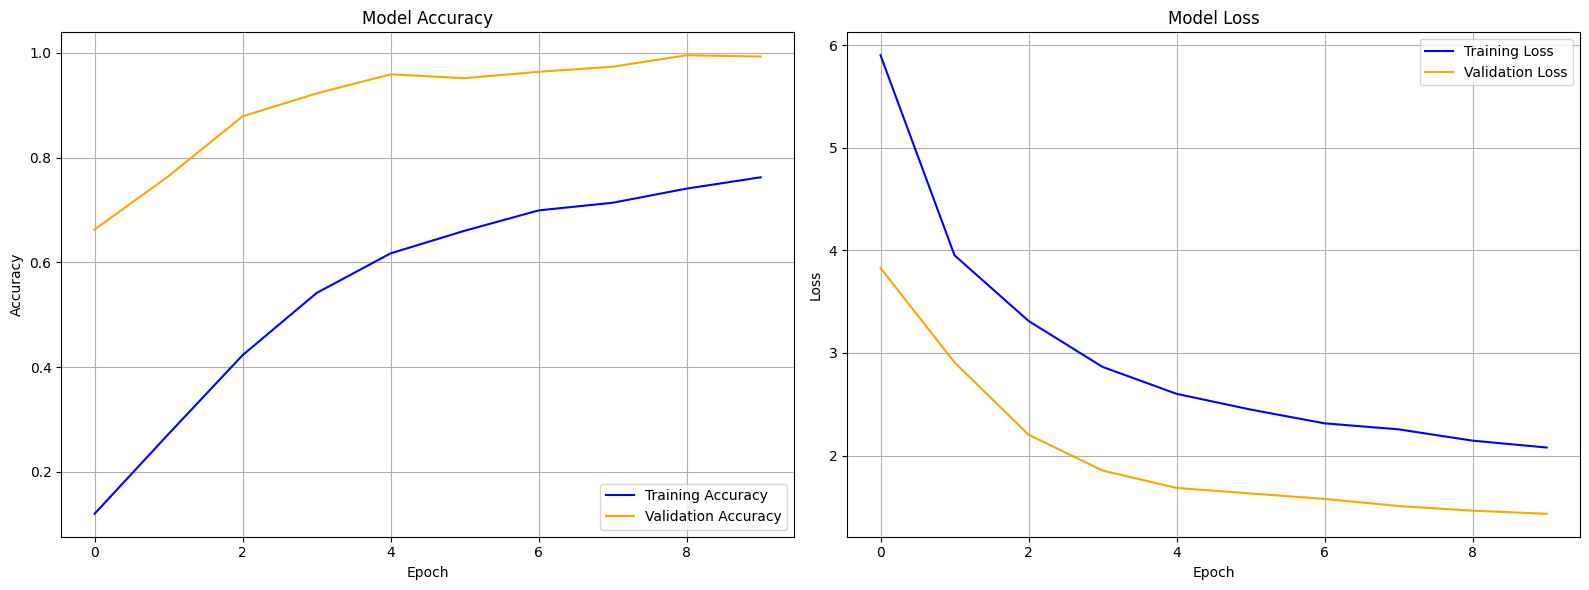

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss', color='blue')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model_vgg16.trainable = False
model_vgg16 = tf.keras.models.Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=27, activation='softmax')
])

model_vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)
model_vgg16.summary()
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    epochs=10
)
loss, accuracy = model_vgg16.evaluate(X_test, Y_test)
print("Accuracy: " + str(accuracy))
print("Loss: " + str(loss))


58889256/58889256 [==============================] - 2s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                      

13/13 [==============================] - 20s 2s/step
Classification Report:
                  precision    recall  f1-score   support

         Balosai       1.00      1.00      1.00        26
       Cream Jam       1.00      0.73      0.84        11
             Doi       1.00      1.00      1.00        14
 Dudh Puli PItha       1.00      0.94      0.97        17
          Faluda       1.00      1.00      1.00        24
       Golap Jam       1.00      1.00      1.00        21
   Hafsi Sondesh       0.86      1.00      0.92        12
          Jilapi       1.00      1.00      1.00        14
    Kacha  Chana       1.00      0.62      0.77        16
     Kacha Golla       0.77      1.00      0.87        20
         Kalojam       1.00      1.00      1.00        15
Kasmiri Chomchom       0.91      0.91      0.91        22
     Lemon Barfi       1.00      1.00      1.00        16
       Malaikari       1.00      1.00      1.00        13
    Maoyaa Laddo       1.00      1.00      1.00      

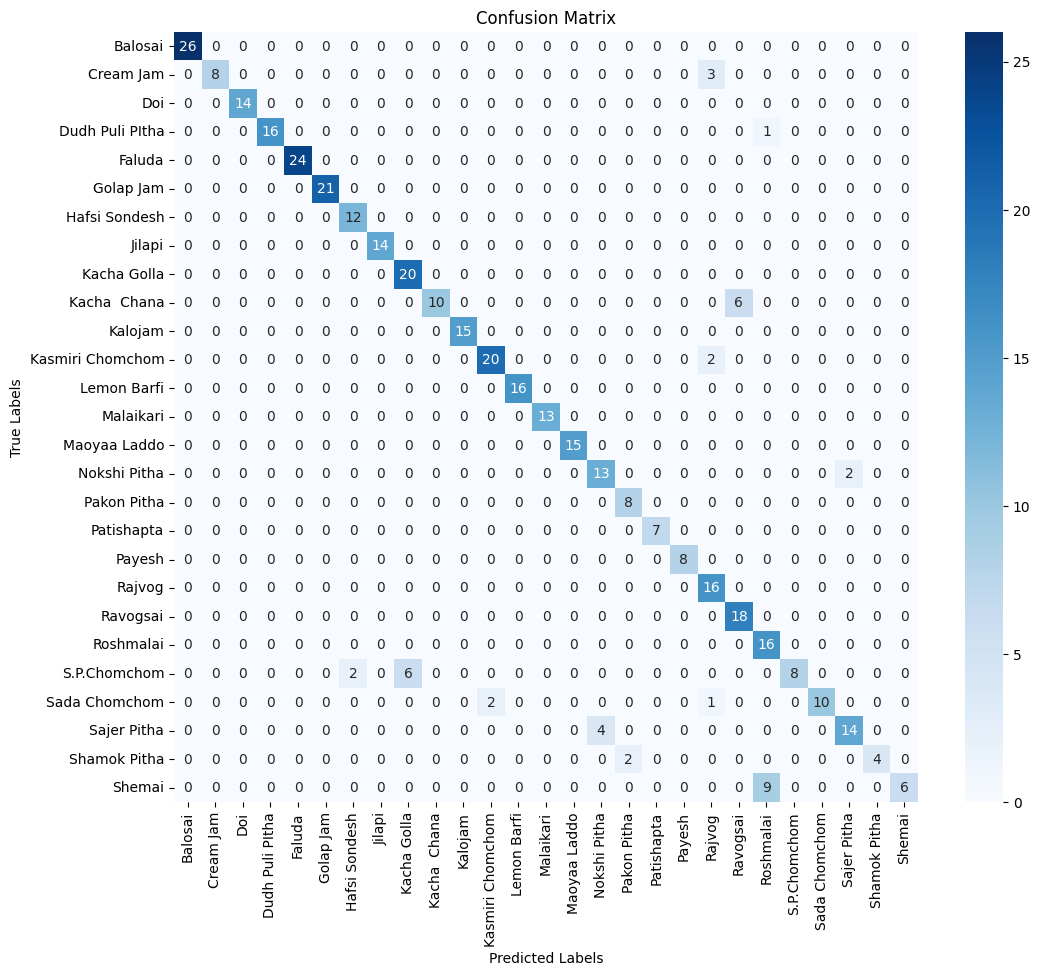

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names = list(labels_dict.keys())
Y_pred = model_vgg16.predict(X_test)
Y_pred_classes = [class_names[np.argmax(pred)] for pred in Y_pred]
Y_true_classes = [class_names[np.argmax(true)] for true in Y_test]
report = classification_report(Y_true_classes, Y_pred_classes)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


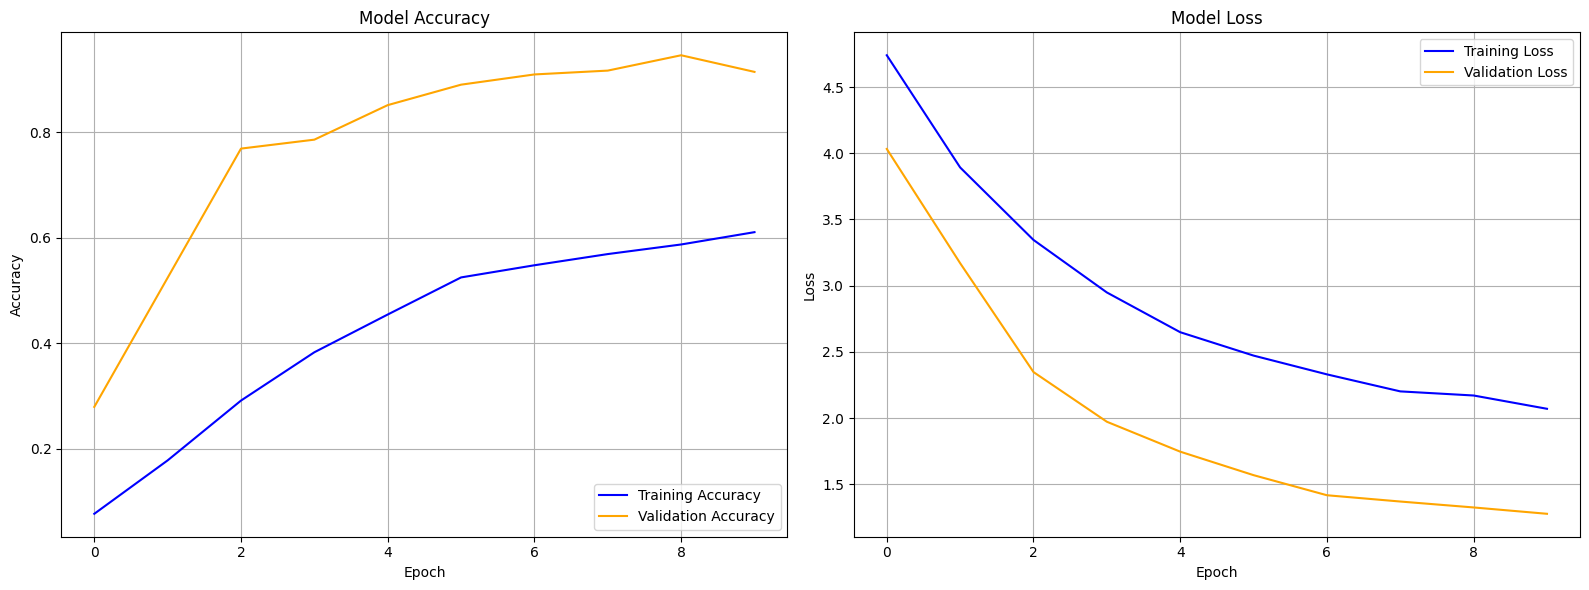

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss', color='blue')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model_vgg19.trainable = False

model_vgg19 = tf.keras.models.Sequential([
    base_model_vgg19,
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=27, activation='softmax')
])

model_vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy']
)
model_vgg19.summary()
history_vgg19 = model_vgg19.fit(
    train_generator,
    validation_data=(X_val, Y_val),
    epochs=10
)
loss, accuracy = model_vgg19.evaluate(X_test, Y_test)
print("Accuracy: " + str(accuracy))
print("Loss: " + str(loss))


80134624/80134624 [==============================] - 2s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                      

13/13 [==============================] - 26s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                  precision    recall  f1-score   support

         Balosai       1.00      1.00      1.00        26
       Cream Jam       1.00      0.36      0.53        11
             Doi       1.00      1.00      1.00        14
 Dudh Puli PItha       1.00      0.94      0.97        17
          Faluda       1.00      1.00      1.00        24
       Golap Jam       1.00      1.00      1.00        21
   Hafsi Sondesh       0.92      1.00      0.96        12
          Jilapi       1.00      1.00      1.00        14
    Kacha  Chana       1.00      1.00      1.00        16
     Kacha Golla       1.00      1.00      1.00        20
         Kalojam       1.00      1.00      1.00        15
Kasmiri Chomchom       0.71      0.77      0.74        22
     Lemon Barfi       1.00      1.00      1.00        16
       Malaikari       0.87      1.00      0.93        13
    Maoyaa Laddo       0.83      1.00      0.91        15
    Nokshi Pitha       0.00      0.00      0.00 

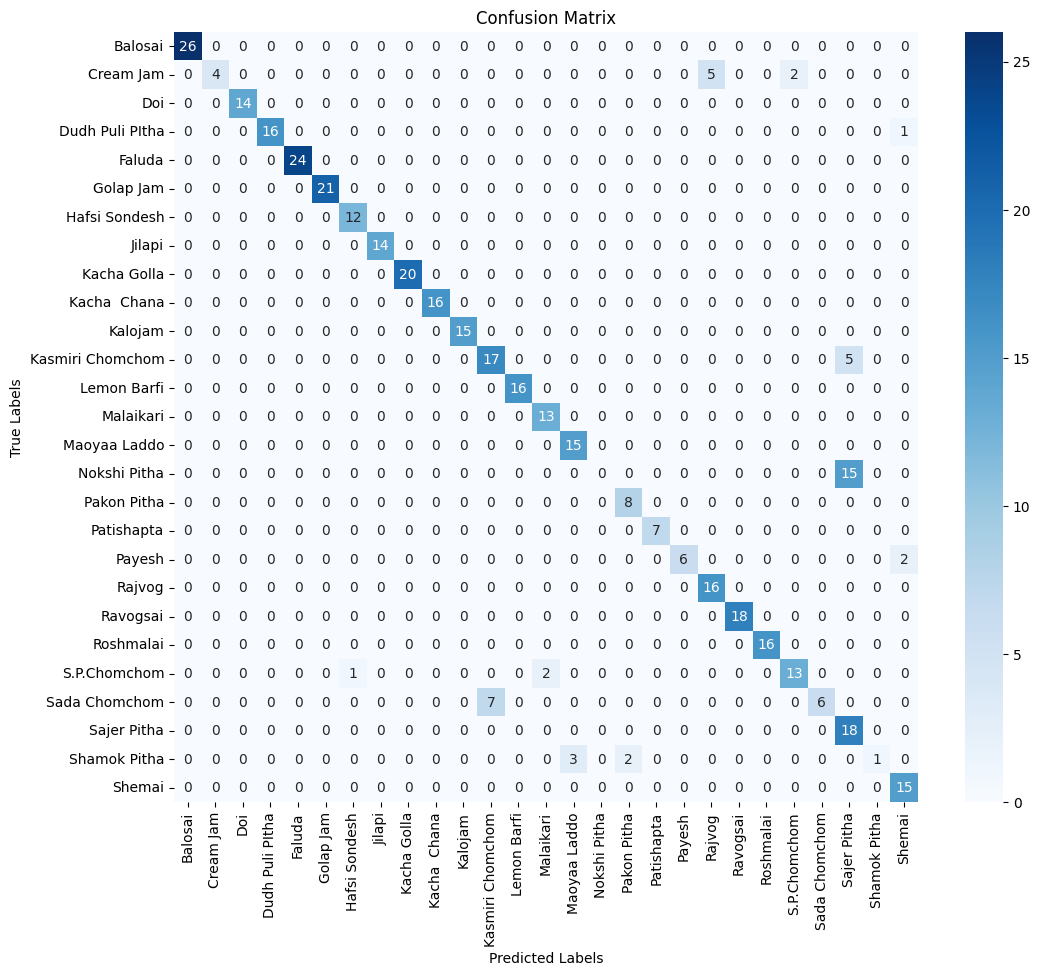

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names = list(labels_dict.keys())
Y_pred = model_vgg19.predict(X_test)
Y_pred_classes = [class_names[np.argmax(pred)] for pred in Y_pred]
Y_true_classes = [class_names[np.argmax(true)] for true in Y_test]
report = classification_report(Y_true_classes, Y_pred_classes)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


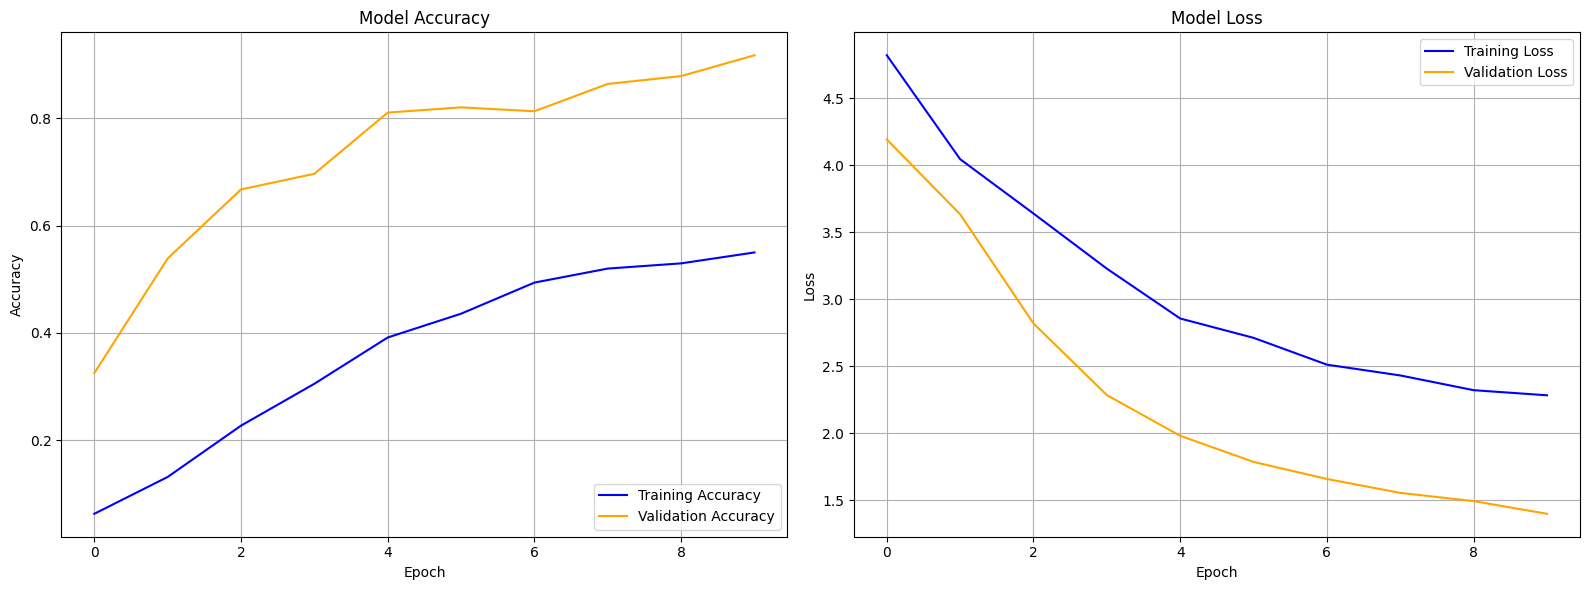

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg19.history['loss'], label='Training Loss', color='blue')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Xception

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import numpy as np

input_shape = (71, 71)
X_train_resized = np.array([cv2.resize(img, input_shape[:2]) for img in X_train])
X_val_resized = np.array([cv2.resize(img, input_shape[:2]) for img in X_val])
X_test_resized = np.array([cv2.resize(img, input_shape[:2]) for img in X_test])

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape + (3,))
base_model_xception.trainable = False
model_xception = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    Dropout(0.7),
    Dense(units=1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(units=27, activation='softmax')
])

model_xception.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_xception.summary()
history_xception = model_xception.fit(
    train_generator,
    validation_data=(X_val_resized, Y_val),
    epochs=10
)

loss, accuracy = model_xception.evaluate(X_test_resized, Y_test)
print("Accuracy: " + str(accuracy))
print("Loss: {:.4f}".format(loss))


83683744/83683744 [==============================] - 2s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_13 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               

13/13 [==============================] - 11s 815ms/step
Classification Report:
                  precision    recall  f1-score   support

         Balosai       1.00      1.00      1.00        26
       Cream Jam       1.00      0.91      0.95        11
             Doi       1.00      1.00      1.00        14
 Dudh Puli PItha       1.00      0.94      0.97        17
          Faluda       0.96      1.00      0.98        24
       Golap Jam       1.00      1.00      1.00        21
   Hafsi Sondesh       0.92      1.00      0.96        12
          Jilapi       1.00      1.00      1.00        14
    Kacha  Chana       0.89      1.00      0.94        16
     Kacha Golla       1.00      1.00      1.00        20
         Kalojam       1.00      1.00      1.00        15
Kasmiri Chomchom       0.95      0.91      0.93        22
     Lemon Barfi       0.94      1.00      0.97        16
       Malaikari       0.93      1.00      0.96        13
    Maoyaa Laddo       0.88      1.00      0.94   

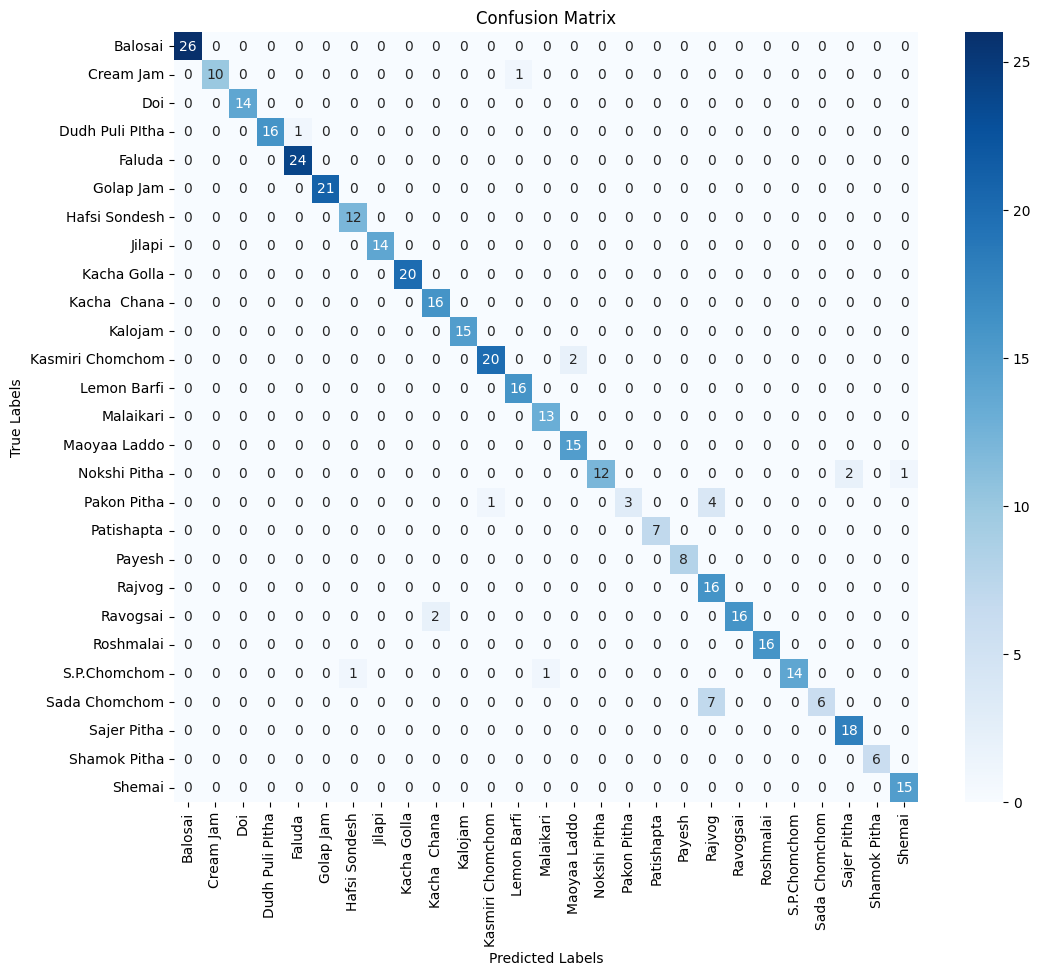

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
class_names = list(labels_dict.keys())
Y_pred = model_xception.predict(X_test_resized)
Y_pred_classes = [class_names[np.argmax(pred)] for pred in Y_pred]
Y_true_classes = [class_names[np.argmax(true)] for true in Y_test]
report = classification_report(Y_true_classes, Y_pred_classes)
print("Classification Report:")
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes, labels=class_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


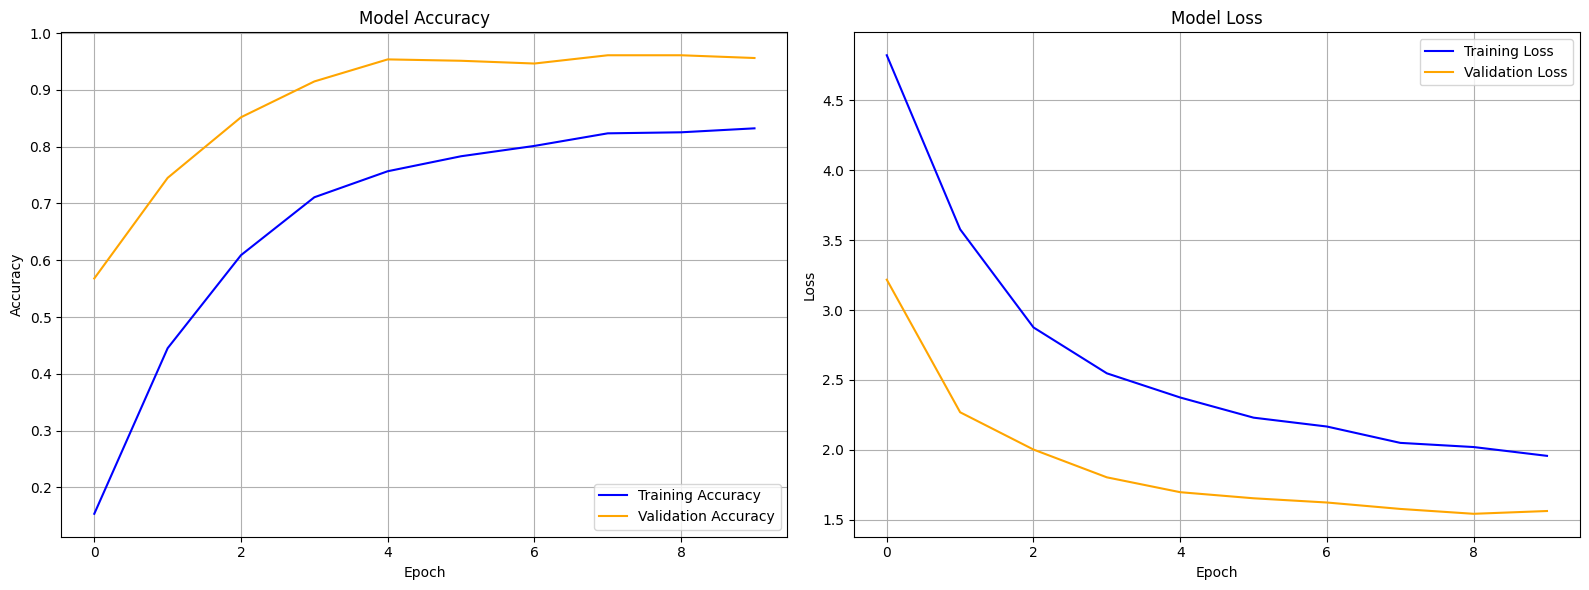

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_xception.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='Training Loss', color='blue')
plt.plot(history_xception.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
